# initilise the chemical space to search 


Notebook showing how we can define the search space with conditions

In [3]:

import os
os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
#os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')
import importlib
import pickle
import pymongo
import pandas as pd
import numpy as np
from stk_search.utils import database_utils


First we need to load the precursor dataframe that defines the building blocks used in the chemical space to search

In [4]:
# load the data and the precursors dataset
importlib.reload(database_utils)
df_precursors_path ="data/output/Prescursor_data/precursor_data_new_clustering.pkl"
df_precursors = pd.read_pickle(df_precursors_path)


Then we can apply some initial filters to the building blocks

In [5]:

def check_mol(mol):
    if mol.GetNumAtoms()>=30:
        return 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() ==14:
            return 0
        if atom.GetAtomicNum() ==32:
            return 0
    return 1
df_precursors['check'] = df_precursors['mol_opt'].apply(check_mol)
df_precursors = df_precursors[df_precursors['check']==1]
df_precursors.drop(columns=['check'], inplace=True)
df_precursors.shape

(274, 47)

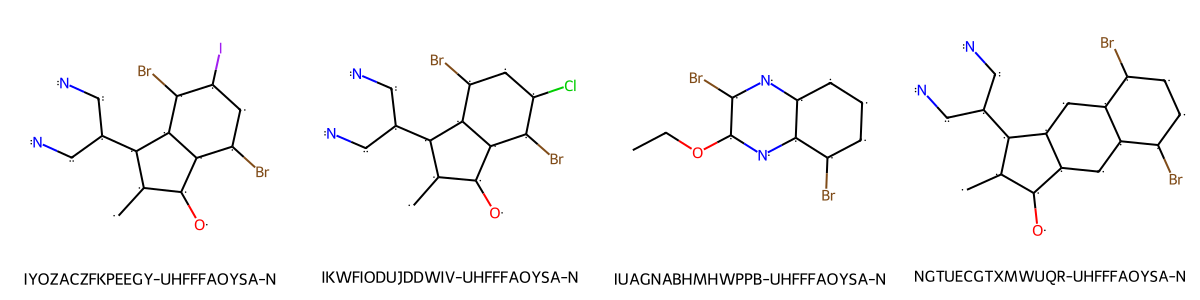

In [6]:
# plot some example of precursors
from rdkit.Chem import Draw
from rdkit import Chem
mol_list = []
mol_label = []
df_to_plot = df_precursors.sample(4)
df_to_plot['mol_opt_smiles'] = df_to_plot['mol_opt'].apply(lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(x)))
mol_list.extend(df_to_plot['mol_opt_smiles'].values)
mol_label.extend(df_to_plot['InChIKey'].values)
# Draw molecules
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(300, 300),legends=[f"{label}" for label in mol_label])  # adjust molsPerRow and subImgSize as needed
img




To define the search space we can set the conditions on the building blocks and the syntax to follow. 

Below we can also use an interactive feature to change the conditions and visualise its impact on the precalculated search space

In [45]:
#%%  generate the search space
from stk_search import SearchSpace
importlib.reload(SearchSpace)

number_of_fragments = 6
target_name = 'target' # specify the target name ( here target refers to the combined property)
aim = 1.0 # specify the target value

SP = SearchSpace.SearchSpace(number_of_fragments=number_of_fragments,df=df_precursors,generation_type='conditional')
print(SP.syntax)
print(SP.conditions_list)

[0, 1, 2, 3, 4, 5]
[[], [], [], [], [], []]


In [47]:
# save the search space
import pickle
save_dir = 'data/input/STK_search_space'
id = 'test'
os.makedirs(save_dir, exist_ok=True)
pickle.dump(SP, open(save_dir+f'/search_space_{id}.pkl', 'wb'))
print(' saved to ', save_dir+f'/search_space_{id}.pkl')

 saved to  data/input/STK_search_space/search_space_test.pkl


the syntax to add conditions on the precursors; for each position of the fragments, we can add a condition on the precursors in the form :

['property_name' #condition# value]

The property name need to be in the precursors dataframe


In [48]:

SP.conditions_list = [
    ["'IP (eV)'#<=#6.5"],
    ["'IP (eV)'#<=#6.5"],
    ["'IP (eV)'#<=#6.5"],
    ["'IP (eV)'#<=#6.5"],
    ["'IP (eV)'#<=#6.5"],
    ["'IP (eV)'#<=#6.5"],
]


In [49]:
# save the search space
import pickle
save_dir = 'data/input/STK_search_space'
id = 'test_limited'
os.makedirs(save_dir, exist_ok=True)
pickle.dump(SP, open(save_dir+f'/search_space_{id}.pkl', 'wb'))
print(' saved to ', save_dir+f'/search_space_{id}.pkl')

 saved to  data/input/STK_search_space/search_space_test_limited.pkl


In [50]:
# load Search space and check conditions
import pickle
save_dir = 'data/input/STK_search_space'
id = 'test_limited'
SP = pickle.load(open(save_dir+f'/search_space_{id}.pkl', 'rb'))
SP.update()
print(SP.syntax)
print(SP.conditions_list)
print(f"size of the search space is : {SP.get_space_size():.2e}")
SP.df_precursors.head()


[0, 1, 2, 3, 4, 5]
[["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"]]
size of the search space is : 6.32e+09


,InChIKey,Atom_num,HOMO (eV),LUMO (eV),HOMO_LUMO_GAP (eV),IP (eV),EA (eV),total energy (eV) vipea,First excited state Energy (eV),First excited osc,...,pca9,check,mol_opt_smiles,mol_org,mol_org_smile,ECFP,num_atoms,num_rings,cluster,orgcluster
0,KYORXLIHDAZXPK-UHFFFAOYSA-N,25,-11.5745,-10.1316,1.442883,7.1531,3.8935,-1699.611759,"[2.97, 3.437, 3.827, 3.901, 4.181]","[0.1323, 0.3332, 0.001, 0.4911, 0.5211]",...,1.909060,1,<rdkit.Chem.rdchem.Mol object at 0x000002B8690...,<rdkit.Chem.rdchem.Mol object at 0x000002B868C...,C=C1C(=O)c2c(sc3ccccc23)C1=C(C#N)C#N,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...",25.0,3.0,0,0
2,UVCFYBOLMFIWGF-FPYGCLRLSA-N,22,-11.6536,-9.8300,1.823610,7.5190,4.1701,-1426.075709,"[3.543, 3.828, 3.987, 4.107, 4.23]","[0.0026, 0.1704, 0.206, 0.2256, 0.0395]",...,0.540030,1,<rdkit.Chem.rdchem.Mol object at 0x000002B867B...,<rdkit.Chem.rdchem.Mol object at 0x000002B8697...,[H]/C=C1\C(=O)c2c(F)cccc2C1=C(C#N)C#N,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...",22.0,2.0,0,2
3,PQZAHLJJGPAGBD-OQFOIZHKSA-N,22,-11.5774,-9.8714,1.706007,7.5324,4.1806,-1426.205720,"[3.779, 3.813, 4.035, 4.115, 4.429]","[0.0002, 0.0277, 0.1648, 0.3408, 0.0013]",...,1.014201,1,<rdkit.Chem.rdchem.Mol object at 0x000002B867B...,<rdkit.Chem.rdchem.Mol object at 0x000002B868C...,[H]/C=C1\C(=O)c2ccc(F)cc2C1=C(C#N)C#N,"[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...",22.0,2.0,0,3
4,HFUBKQHDPJZQIW-UHFFFAOYSA-N,13,-11.6185,-9.5986,2.019861,7.7105,3.7821,-1085.337355,"[4.436, 4.438, 5.127, 5.751, 5.826]","[0.2419, 0.2902, 0.0, 0.0, 0.0098]",...,1.085874,1,<rdkit.Chem.rdchem.Mol object at 0x000002B8661...,<rdkit.Chem.rdchem.Mol object at 0x000002B868C...,Fc1cc2c(cc1F)N=S=N2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, ...",13.0,2.0,1,4
5,XORWEKRDQCXPID-UHFFFAOYSA-N,28,-11.3061,-9.1919,2.114258,7.1941,3.5724,-1474.375137,"[3.81, 3.855, 4.251, 4.645, 4.799]","[0.1441, 0.2486, 0.0869, 0.0024, 0.0025]",...,0.097783,1,<rdkit.Chem.rdchem.Mol object at 0x000002B8697...,<rdkit.Chem.rdchem.Mol object at 0x000002B868C...,CCN1C(=O)c2cccc3cccc(c23)C1=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",28.0,3.0,1,5


## Using the prior information and an iteractive tool to set the search space

In [10]:
df_total_path = "data/output/Full_dataset/New_target07072024.csv"
df_total_new = pd.read_csv(df_total_path)
print(df_total_new.columns)
df_total_new , df_precursors= database_utils.load_data_from_file(df_total_path, df_precursors_path,add_feature_frag=True)
df_total_new['target'] = (
        -np.abs(df_total_new["ES1"] - 3)
        - np.abs(df_total_new["ionisation potential (eV)"] - 5.5)
        + np.log10(df_total_new["fosc1"])
    )

Index(['Unnamed: 0', 'InChIKey', 'BB', 'electron affinity (eV)',
       'homo lumo_gap (eV)', 'ionisation potential (eV)', 'total energy (au)',
       'ES1', 'fosc1', 'InChIKey_0', 'InChIKey_1', 'InChIKey_2', 'InChIKey_3',
       'InChIKey_4', 'InChIKey_5'],
      dtype='object')


In [15]:
#%%  generate the search space
from stk_search import SearchedSpace
importlib.reload(SearchedSpace)

number_of_fragments = 6
target_name = 'target' # specify the target name ( here target refers to the combined property)
aim = 1.0 # specify the target value

SP = SearchedSpace.SearchedSpace(number_of_fragments=number_of_fragments,df=df_precursors,generation_type='conditional')
SP.generate_interactive_condition_V2(df_total=df_total_new,properties_to_plot=["electron affinity (eV)","target"])

In [16]:
import glob
#%% 

search_spaces_dfs = glob.glob('data/*pkl')
for id,df_path_SP in enumerate(search_spaces_dfs):
    print(id,df_path_SP)


0 data\search_space_properties.pkl
1 data\search_space_properties_2023_09_11_12_03_15.pkl
2 data\search_space_properties_2023_09_21_16_41_29.pkl
3 data\search_space_properties_2023_09_22_09_04_06.pkl
4 data\search_space_properties_2023_10_30_11_19_54.pkl
5 data\search_space_properties_2023_10_30_15_51_43.pkl
6 data\search_space_properties_2023_10_30_15_52_38.pkl
7 data\search_space_properties_2023_10_30_15_54_12.pkl
8 data\search_space_properties_2023_10_30_15_54_29.pkl
9 data\search_space_properties_2023_10_30_16_15_58.pkl
10 data\search_space_properties_2023_10_30_16_20_54.pkl
11 data\search_space_properties_2024_05_07_11_27_14.pkl
12 data\search_space_properties_2024_05_08_14_43_36.pkl
13 data\search_space_properties_2024_05_09_16_28_25.pkl
14 data\search_space_properties_2024_05_10_12_38_46.pkl


In [17]:
df_SP = pd.read_pickle(search_spaces_dfs[3])
df_SP.reset_index(drop=True,inplace=True)
df_SP

,number of elements,syntax,conditions,Elements in top 5%,number of elements evaluated
0,922417564483584,"[0, 1, 2, 3, 4, 5]","[['IP (eV)'#<=#6.5], ['IP (eV)'#<=#6.5], ['IP ...",0,0
1,274625,"(0, 1, 2, 2, 1, 0)","[['IP (eV)'#<=#6.5], ['IP (eV)'#<=#6.5], ['IP ...",6.567796610169492,4.72e+02
2,274625,"(0, 1, 2, 2, 1, 0)","[['IP (eV)'#<=#6.5], ['IP (eV)'#<=#6.5], ['IP ...",6.567796610169492,4.72e+02


In [40]:
# load the saved dataframe with all the tested conditions
# and output it in order to select a few to add to the bactk experiment

import pickle
from datetime import datetime
import os

def save_SP_for_EXP(df:pd.DataFrame,index_list:list,exp_name:str,number_of_fragments):
    time_now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    save_dir = f'data/input/EXP_search_space/{exp_name}_{time_now}/'
    os.makedirs(save_dir,exist_ok=True)
    SP = SearchedSpace.SearchedSpace(number_of_fragments=number_of_fragments,df=df_precursors,generation_type='conditional')
    for id in index_list:
        SP.conditions_list = df['conditions'].values[id]
        SP.syntax = list(df['syntax'].values[id])[:number_of_fragments]
        SP.update()
        print(f"size of the search space is : {SP.space_size:.2e}")
        print(SP.syntax)
        print(SP.conditions_list)
        pickle.dump(SP,file=open(save_dir+f'/search_space_{id}.pkl','wb'))
        print(' saved to ', save_dir+f'/search_space_{id}.pkl')
    return SP, save_dir
experiment_name = '6_mers_filtered_BB'
SP,save_dir= save_SP_for_EXP(df_SP,[0],experiment_name,number_of_fragments)

size of the search space is : 6.32e+09
[0, 1, 2, 3, 4, 5]
[["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"], ["'IP (eV)'#<=#6.5"]]
 saved to  data/input/EXP_search_space/6_mers_filtered_BB_2024_07_09_15_14_44//search_space_0.pkl
